## NAC player classification

In [29]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer


#### Bin feature

In [73]:
NAC_data = 'NAC_data.csv'
file = pd.read_csv(NAC_data)
NAC_df = pd.DataFrame(file)

min_val = NAC_df['Market value'].min()
max_val = NAC_df['Market value'].max()
bins = [min_val, 1000000, 5000000, max_val]
labels = ['Lower', 'Middle', 'Higher']

NAC_df['Bin'] = pd.cut(NAC_df['Market value'], bins=bins, labels=labels, include_lowest=True) # Binning the market values 

In [44]:
# Splitting the dataset into testing and training sets
X = NAC_df[['Goals', 'Age', 'xG', 'Duels per 90', 'Height', 'Assists per 90']]
y = NAC_df['Bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using one-hot encoding for adressing categorical data
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Handling NaN values using a simple imputer
imputer = SimpleImputer(strategy='mean')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns)

#### Logistic Regression

In [48]:
# Instantiating and fitting the model
log_reg = LogisticRegression(max_iter=50000)
log_reg.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_encoded)

              precision    recall  f1-score   support

      Higher       0.15      0.11      0.12        28
       Lower       0.92      0.97      0.95      3037
      Middle       0.18      0.06      0.09       242

    accuracy                           0.90      3307
   macro avg       0.42      0.38      0.39      3307
weighted avg       0.86      0.90      0.88      3307



Text(0.5, 23.52222222222222, 'Predicted values')

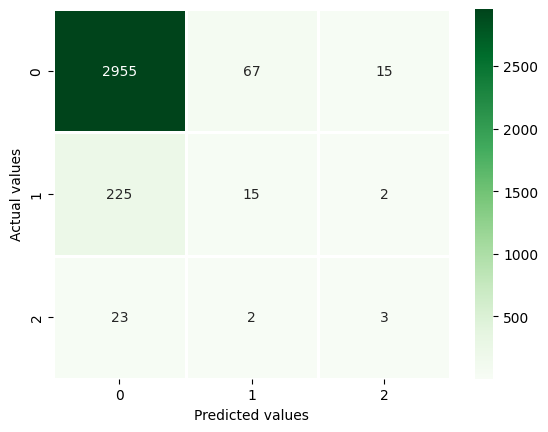

In [53]:
# Model Evaluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['Lower', 'Middle', 'Higher'])
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g', linewidths=2)
plt.ylabel('Actual values')
plt.xlabel('Predicted values')

Interpreting the results:

The model performs well in predicting instances labeled as "Lower" with high precision and recall.

It struggles with predicting instances labeled as "Middle," with low precision and recall.

The class "Higher" is not predicted at all (I believe it is because the denominator might be 0).

#### KNN model

In [51]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_encoded, y_train)

print(knn.score(X_test_encoded, y_test))

y_pred = knn.predict(X_test_encoded)

0.8990021167221046


              precision    recall  f1-score   support

      Higher       0.15      0.11      0.12        28
       Lower       0.92      0.97      0.95      3037
      Middle       0.18      0.06      0.09       242

    accuracy                           0.90      3307
   macro avg       0.42      0.38      0.39      3307
weighted avg       0.86      0.90      0.88      3307



Text(0.5, 23.52222222222222, 'Predicted values')

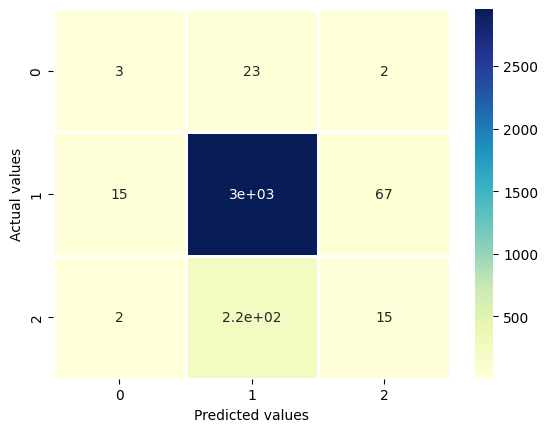

In [54]:
# Model Evaluation
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu", linewidths=2)
plt.ylabel('Actual values')
plt.xlabel('Predicted values')

Interpreting the results:

The model performs well in predicting instances labeled as "Lower" with high precision and recall.

The model struggles with predicting instances labeled as "Higher" and "Middle."

The low precision and recall for "Middle" suggest that the model might need improvements in distinguishing this class.

### Feature

In [82]:
# I decided to split a row with a player that has multiple positions into multiple rows but with different positions
# in order to make it eacier to calculate statistics

exploded_df = NAC_df.explode('Position')

# Reset the index
exploded_df.reset_index(drop=True, inplace=True)

print(exploded_df)

       Unnamed: 0          Player                   Team  \
0               0     P. Iemmello              Catanzaro   
1               1  J. Petriccione                Crotone   
2               1  J. Petriccione                Crotone   
3               1  J. Petriccione                Crotone   
4               2       T. Biasci              Catanzaro   
...           ...             ...                    ...   
32698       16532    B. Bozhurkin             Hebar 1918   
32699       16533       M. Petkov  Ceahlăul Piatra Neamţ   
32700       16533       M. Petkov  Ceahlăul Piatra Neamţ   
32701       16534     I. Mihaylov        Septemvri Sofia   
32702       16534     I. Mihaylov        Septemvri Sofia   

      Team within selected timeframe Position   Age  Market value  \
0                          Catanzaro       CF  31.0        750000   
1                            Crotone      DMF  28.0        700000   
2                            Crotone     RDMF  28.0        700000   
3  

I created an aglorithm that calculates which team has the better player for a certain position, based on the team's average value. It is easily modifiable depending on which position is inputed.

I believe it would be useful for NAC Breda in situations where they lack good players in a certian position and they wish to analyze other teams' (who have good players for a certain position) selection process, training procedure, and maybe even look into buying that player, etc.

In [83]:
# Filter for players with 'CF' position
cf_players = exploded_df[exploded_df['Position'] == 'CF']

# Group by team and calculate the average market value for the team
average_market_value = cf_players.groupby('Team')['Market value'].mean().reset_index()

# Find the team with the highest average market value
best_team = average_market_value.loc[average_market_value['Market value'].idxmax()]

print(f"The team with the best center forwards is: {best_team['Team']}")
print(f"Their average market value is: {best_team['Market value']}")

The team with the best center forwards is: RB Leipzig
Their average market value is: 25000000.0
